Install packages

In [1]:
!git clone https://github.com/stefanknegt/Probabilistic-Unet-Pytorch.git

fatal: destination path 'Probabilistic-Unet-Pytorch' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append('Probabilistic-Unet-Pytorch/')

Download seismic and interpretations:

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='133XNGEsOPEqU9JNaCIfslN2LfnhTeLDD',
                                    dest_path='/content/data.zip',
                                    unzip=True)


In [4]:
!unzip "./data/train/fault.zip" -d "data/train/"

Archive:  ./data/train/fault.zip
replace data/train/fault/58.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/train/fault/58.dat  
  inflating: data/train/fault/64.dat  
  inflating: data/train/fault/70.dat  
  inflating: data/train/fault/165.dat  
  inflating: data/train/fault/171.dat  
  inflating: data/train/fault/159.dat  
  inflating: data/train/fault/158.dat  
  inflating: data/train/fault/170.dat  
  inflating: data/train/fault/164.dat  
  inflating: data/train/fault/71.dat  
  inflating: data/train/fault/65.dat  
  inflating: data/train/fault/59.dat  
  inflating: data/train/fault/9.dat  
  inflating: data/train/fault/73.dat  
  inflating: data/train/fault/199.dat  
  inflating: data/train/fault/67.dat  
  inflating: data/train/fault/172.dat  
  inflating: data/train/fault/166.dat  
  inflating: data/train/fault/98.dat  
  inflating: data/train/fault/167.dat  
  inflating: data/train/fault/99.dat  
  inflating: data/train/fault/173.dat  
  inflating: data/train/fa

In [5]:
import numpy as np
import keras
import random

import tensorflow as tf
from tensorflow.keras.utils import to_categorical


This is Xinming Wu's keras dataloader:

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
  'Generates data for keras'
  def __init__(self,dpath,fpath,data_IDs, batch_size=1, dim=(128,128,128), 
             n_channels=1, shuffle=True):
    'Initialization'
    self.dim   = dim
    self.dpath = dpath
    self.fpath = fpath
    self.batch_size = batch_size
    self.data_IDs   = data_IDs
    self.n_channels = n_channels
    self.shuffle    = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.data_IDs)/self.batch_size))

  def __getitem__(self, index):
    'Generates one batch of data'
    # Generate indexes of the batch
    bsize = self.batch_size
    indexes = self.indexes[index*bsize:(index+1)*bsize]

    # Find list of IDs
    data_IDs_temp = [self.data_IDs[k] for k in indexes]

    # Generate data
    X, Y = self.__data_generation(data_IDs_temp)

    return X, Y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.data_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, data_IDs_temp):
    'Generates data containing batch_size samples'
    # Initialization
    gx  = np.fromfile(self.dpath+str(data_IDs_temp[0])+'.dat',dtype=np.single)
    fx  = np.fromfile(self.fpath+str(data_IDs_temp[0])+'.dat',dtype=np.single)
    gx = np.reshape(gx,self.dim)
    fx = np.reshape(fx,self.dim)
    #gmin = np.min(gx)
    #gmax = np.max(gx)
    #gx = gx-gmin
    #gx = gx/(gmax-gmin)
    #gx = gx*255
    xm = np.mean(gx)
    xs = np.std(gx)
    gx = gx-xm
    gx = gx/xs
    gx = np.transpose(gx)
    fx = np.transpose(fx)
    #in seismic processing, the dimensions of a seismic array is often arranged as
    #a[n3][n2][n1] where n1 represnts the vertical dimenstion. This is why we need 
    #to transpose the array here in python 
    # Generate data
    X = np.zeros((2, *self.dim, self.n_channels),dtype=np.single)
    Y = np.zeros((2, *self.dim, self.n_channels),dtype=np.single)
    X[0,] = np.reshape(gx, (*self.dim,self.n_channels))
    Y[0,] = np.reshape(fx, (*self.dim,self.n_channels))  
    X[1,] = np.reshape(np.flipud(gx), (*self.dim,self.n_channels))
    Y[1,] = np.reshape(np.flipud(fx), (*self.dim,self.n_channels))  
    '''
    for i in range(4):
      X[i,] = np.reshape(np.rot90(gx,i,(2,1)), (*self.dim,self.n_channels))
      Y[i,] = np.reshape(np.rot90(fx,i,(2,1)), (*self.dim,self.n_channels))  
    '''
    return X,Y



In [7]:
  # input image dimensions
  params = {'batch_size':1,
          'dim':(128,128,128),
          'n_channels':1,
          'shuffle': True}
  seismPathT = "./data/train/seis/"
  faultPathT = "./data/train/fault/"

  seismPathV = "./data/validation/seis/"
  faultPathV = "./data/validation/fault/"

  train_ID = range(200)
  valid_ID = range(20)

  train_generator = DataGenerator(dpath=seismPathT,fpath=faultPathT,
                                  data_IDs=train_ID,**params)
  
  valid_generator = DataGenerator(dpath=seismPathV,fpath=faultPathV,
                                  data_IDs=valid_ID,**params)

Here I turn it into numpy arrays:

In [17]:
X_train = np.zeros((10, 2, 128,128,128, 1))
Y_train = np.zeros((10, 2, 128,128,128, 1))

for n, index in enumerate(range(10)):
  X_train[n,...], Y_train[n,...] = train_generator.__getitem__(index)


X_val = np.zeros((10, 2, 128,128,128, 1))
Y_val = np.zeros((10, 2, 128,128,128, 1))

for n, index in enumerate(range(10)):
  X_val[n,...], Y_val[n,...] = valid_generator.__getitem__(index)

Now I try to load it with the pytorch dataloader:

In [14]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [18]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

TypeError: ignored

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from probabilistic_unet import ProbabilisticUnet
from utils import l2_regularisation
from tqdm.auto import tqdm, trange

In [ ]:
class Logger(object):
    def __init__(self):
        self.metrics = ['elbo', 'reconstruction_loss', 'mse_loss', 'std', 'kl diveregence', 'reg_loss']
        self.lists = [[], [], [], [], [], []]
        self.steps = []
    def step(self, global_step, *args):
        for i, value in enumerate(args):
            self.lists[i].append(value.item())
        self.steps.append(global_step)

Here we need to adjust the dimensions:

In [ ]:
net = ProbabilisticUnet(input_channels=1, 
                        num_classes=1, 
                        num_filters=[4,8,16,32], 
                        latent_dim=4, 
                        no_convs_fcomb=2, 
                        beta=1.0)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=0)
epochs = 10
global_step = 0
save_every_steps = 5
summary = SummaryWriter("tensorboard" + datetime.now().strftime('%d%m%y%H%M:%S'))
nsamples = 64
mse_criteria = nn.MSELoss()
logger = Logger()
for epoch in trange(epochs, desc = 'epochs'):
    for step in trange(len(train_loader), desc='batches', leave=False):
        patch, mask = next(iter(train_loader))
        patch = patch.to(device)
        mask = mask.to(device)
        net.forward(patch, mask, training=True)
        elbo = net.elbo(mask)
        reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
        loss = -elbo + 1e-5 * reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if global_step % save_every_steps == 0:
            mean_pred = torch.zeros_like(mask)
            mean_sq_pred = torch.zeros_like(mask)
            for _ in range(nsamples):
                mean_pred += net.sample()
                mean_sq_pred += mean_pred**2
            mean_pred /= nsamples
            mean_sq_pred /= nsamples
            var_pred = (mean_sq_pred - mean_pred**2)
            mse = mse_criteria(mask, mean_pred)
            std = var_pred.mean()**0.5
            logger.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
            summary.add_scalar("elbo",elbo,global_step)
            summary.add_scalar("reconstruction_loss",net.reconstruction_loss,global_step)
            summary.add_scalar("mse_loss",mse,global_step)
            summary.add_scalar("std",std,global_step)
            summary.add_scalar("kl diveregence",net.kl,global_step)
            summary.add_scalar("reg_loss",reg_loss,global_step)
        global_step += 1

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

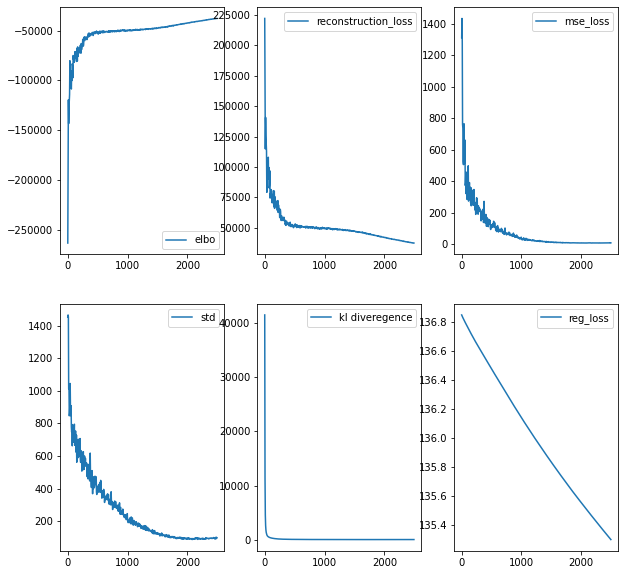

In [ ]:
ncols = 3
nrows = len(logger.metrics) // ncols
fig, axs = plt.subplots(figsize = (10, 10), ncols = ncols, nrows = nrows)
for i, name in enumerate(logger.metrics):
    axs.flatten()[i].plot(logger.steps, logger.lists[i], label = name)
    axs.flatten()[i].legend()

In [ ]:
patch, mask = next(iter(train_loader))
net.forward(patch.to(device), None, training=False)

tensor([[-6.3809e-01, -4.1944e+00, -1.1157e+00,  ..., -8.7225e-01,
         -8.7225e-01, -2.1092e+00],
        [-3.6316e-01, -4.8413e+00, -9.4706e-01,  ..., -2.9975e-01,
         -8.7225e-01, -5.0844e+00],
        [-1.0540e-01, -5.1792e-05, -1.9212e+00,  ..., -5.1792e-05,
         -4.1192e-01, -1.4121e+01],
        ...,
        [-5.1792e-05, -5.1792e-05, -1.3610e+00,  ..., -8.7225e-01,
         -5.1792e-05, -5.1792e-05],
        [-5.1792e-05, -5.1792e-05, -8.7225e-01,  ..., -1.3714e+00,
         -8.7225e-01, -1.4981e+00],
        [-5.1792e-05, -5.1792e-05, -9.9747e-01,  ..., -3.4820e+00,
         -3.4204e+00, -5.1792e-05]])
tensor([[-3.1465e+00, -1.7055e+00, -2.6357e+00,  ..., -2.4108e+00,
         -2.4108e+00, -3.6253e+00],
        [-2.8715e+00, -2.0522e+00, -2.4697e+00,  ..., -2.8105e+00,
         -2.4108e+00, -2.5935e+00],
        [-2.6138e+00, -5.5757e-01, -3.5084e+00,  ..., -2.5055e+00,
         -2.9243e+00, -1.0118e+01],
        ...,
        [-9.3487e-01, -5.1792e-05, -3.1778e+00

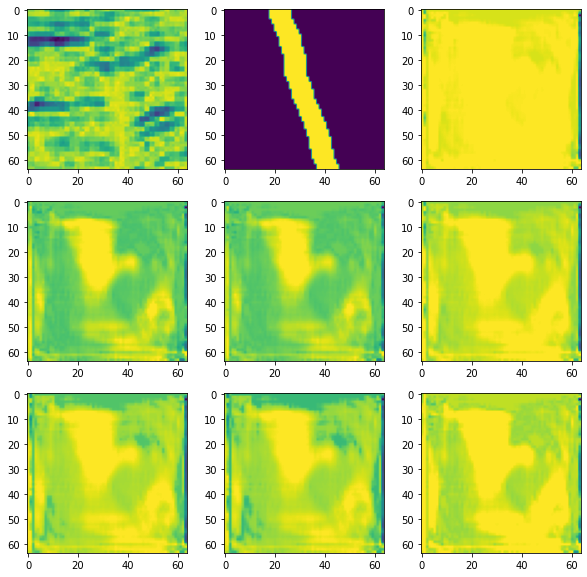

In [ ]:
i = np.random.randint(batch_size)

nsamples = 7
ncols = 3
nrows = (nsamples+2) // ncols
fig, axs = plt.subplots(figsize = (10, 10), ncols = ncols, nrows = nrows)
axs.flatten()[0].imshow(patch[i,0])
axs.flatten()[1].imshow(mask[i,0])
for j in range(nsamples):
    pred_mask = net.sample().detach().cpu()
    axs.flatten()[j+2].imshow(pred_mask[i,0])
    print(pred_mask[i,0])